In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torch.nn.functional as F

In [2]:
# load file npz

DATA_PATH = './New_dictionary'

## Shape analysis

In [3]:
shapes = []
for file in os.listdir(DATA_PATH):
    if file.endswith('.npy'):
        pat = np.load(DATA_PATH + '/' + file, allow_pickle=True).item()
        shapes.append([pat['interpolated_intensity'].shape, 
                       pat['interpolated_segmentation'].shape,
                       pat['mask_foreground'].shape])
shape_vect = np.array(shapes)

In [4]:
category_names = list(pat.keys())[:3]

for cat in range(shape_vect.shape[1]):
    print(f'Analysis of category {category_names[cat]}:')
    shape_val = shape_vect[:, cat, :]

    unique, counts = np.unique(shape_val, axis=0, return_counts=True)
    for u, c in zip(unique, counts):
        print(f'Shape {u}, {c}')
    print('\n')



Analysis of category interpolated_intensity:
Shape [384 384  20], 418
Shape [384 384  21], 8
Shape [384 384  22], 55
Shape [384 384  24], 3
Shape [432 432  20], 1
Shape [480 480  20], 1
Shape [560 560  20], 1


Analysis of category interpolated_segmentation:
Shape [384 384  20], 418
Shape [384 384  21], 8
Shape [384 384  22], 55
Shape [384 384  24], 3
Shape [432 432  20], 1
Shape [480 480  20], 1
Shape [560 560  20], 1


Analysis of category mask_foreground:
Shape [384 384  20], 418
Shape [384 384  21], 8
Shape [384 384  22], 55
Shape [384 384  24], 3
Shape [432 432  20], 1
Shape [480 480  20], 1
Shape [560 560  20], 1




In [5]:
shape_vect[0]

array([[384, 384,  20],
       [384, 384,  20],
       [384, 384,  20]])

In [6]:
pat.keys()

dict_keys(['interpolated_intensity', 'interpolated_segmentation', 'mask_foreground', 'affine_cine', 'resolution_cine', 'dimensions'])

(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

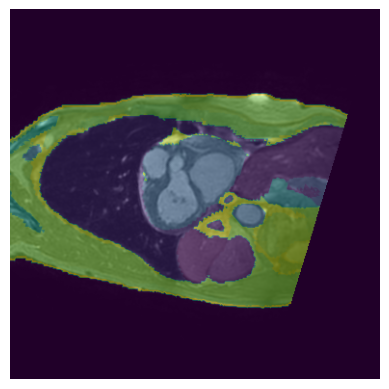

In [7]:
plt.imshow(pat['interpolated_intensity'][:,:,10], cmap='gray')
plt.imshow(pat['interpolated_segmentation'][:,:,10], cmap='viridis', alpha=0.5)
plt.axis('off')

## Label Analysis

In [8]:
original_labels = []

with open (DATA_PATH + '/tissue_list.txt', 'r') as f:

    for i, line in enumerate(f):
        if i > 1:
            line = line.strip().split()[-1]
            original_labels.append(line)
        
print(original_labels)

['Spleen', 'Kidney_right', 'Kidney_left', 'Gallbladder_bile', 'Liver', 'Stomach_lumen', 'Pancreas', 'Adrenal_gland_right', 'Adrenal_gland_left', 'Lung', '__unused__', '__unused__', '__unused__', '__unused__', 'Esophagus_lumen', 'Trachea_lumen', 'Thyroid_gland', 'Intestine_lumen', 'Small_intestine_duodenum', '__unused__', '__unused__', '__unused__', '__unused__', 'Heart', 'Aorta', 'Vein_pulmonary', 'Artery_brachiocephalic', 'Artery_subclavian_right', 'Artery_subclavian_left', 'Artery_common_carotid_right', 'Artery_common_carotid_left', 'Vein_brachiocephalic_left', 'Vein_brachiocephalic_right', 'Atrial_appendage_left', 'Vena_cava_superior', 'Vena_cava_inferior', 'Vein_portal_and_splenic', '__unused__', '__unused__', '__unused__', '__unused__', 'Humerus_left', '__unused__', 'Scapula_left', 'Scapula_right', 'Clavicle_left', 'Clavicle_right', '__unused__', '__unused__', '__unused__', 'Pelvis_right', 'Spinal_cord', '__unused__', '__unused__', '__unused__', '__unused__', '__unused__', '__unus

In [9]:
# load a generic patient 
pat_files = sorted(os.listdir(DATA_PATH))
pat_idx_false = np.random.randint(0, len(pat_files))

pat = np.load(DATA_PATH + '/' + pat_files[pat_idx_false], allow_pickle=True).item()


In [10]:
print('Pat ID:', pat_files[pat_idx_false].split('-')[1])

Pat ID: 010


Slice number: 12


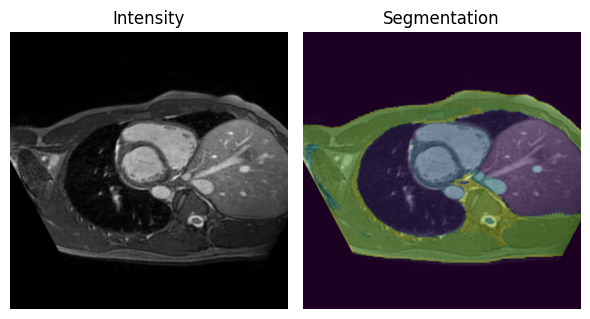

In [11]:
slice_idx = np.random.randint(0, pat['interpolated_intensity'].shape[2])

ex_slice = pat['interpolated_intensity'][:,:,slice_idx]
ex_segmentation = np.round(pat['interpolated_segmentation'][:,:,slice_idx])
print(f'Slice number: {slice_idx}')

fig, ax = plt.subplots(1, 2, figsize=(6, 6))

ax[0].imshow(ex_slice, cmap='gray')
ax[0].set_title('Intensity')
ax[0].axis('off')
ax[1].imshow(ex_slice, cmap='gray')
ax[1].imshow(ex_segmentation, cmap='viridis', alpha=0.4)
ax[1].set_title('Segmentation')
ax[1].axis('off')
plt.tight_layout()


[0.00000000e+00 2.88174106e-06 7.85393902e-06 ... 2.18932353e+03
 2.21179566e+03 2.23627325e+03]


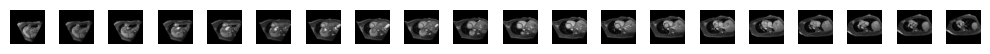

In [12]:
slices_black = pat['interpolated_intensity'][:,:,:]
fig, ax = plt.subplots(1, slices_black.shape[2], figsize=(10, 10))
for i in range(slices_black.shape[2]):
    ax[i].imshow(slices_black[:,:,i], cmap='gray')
    ax[i].axis('off')
plt.tight_layout()

print(np.unique(slices_black))

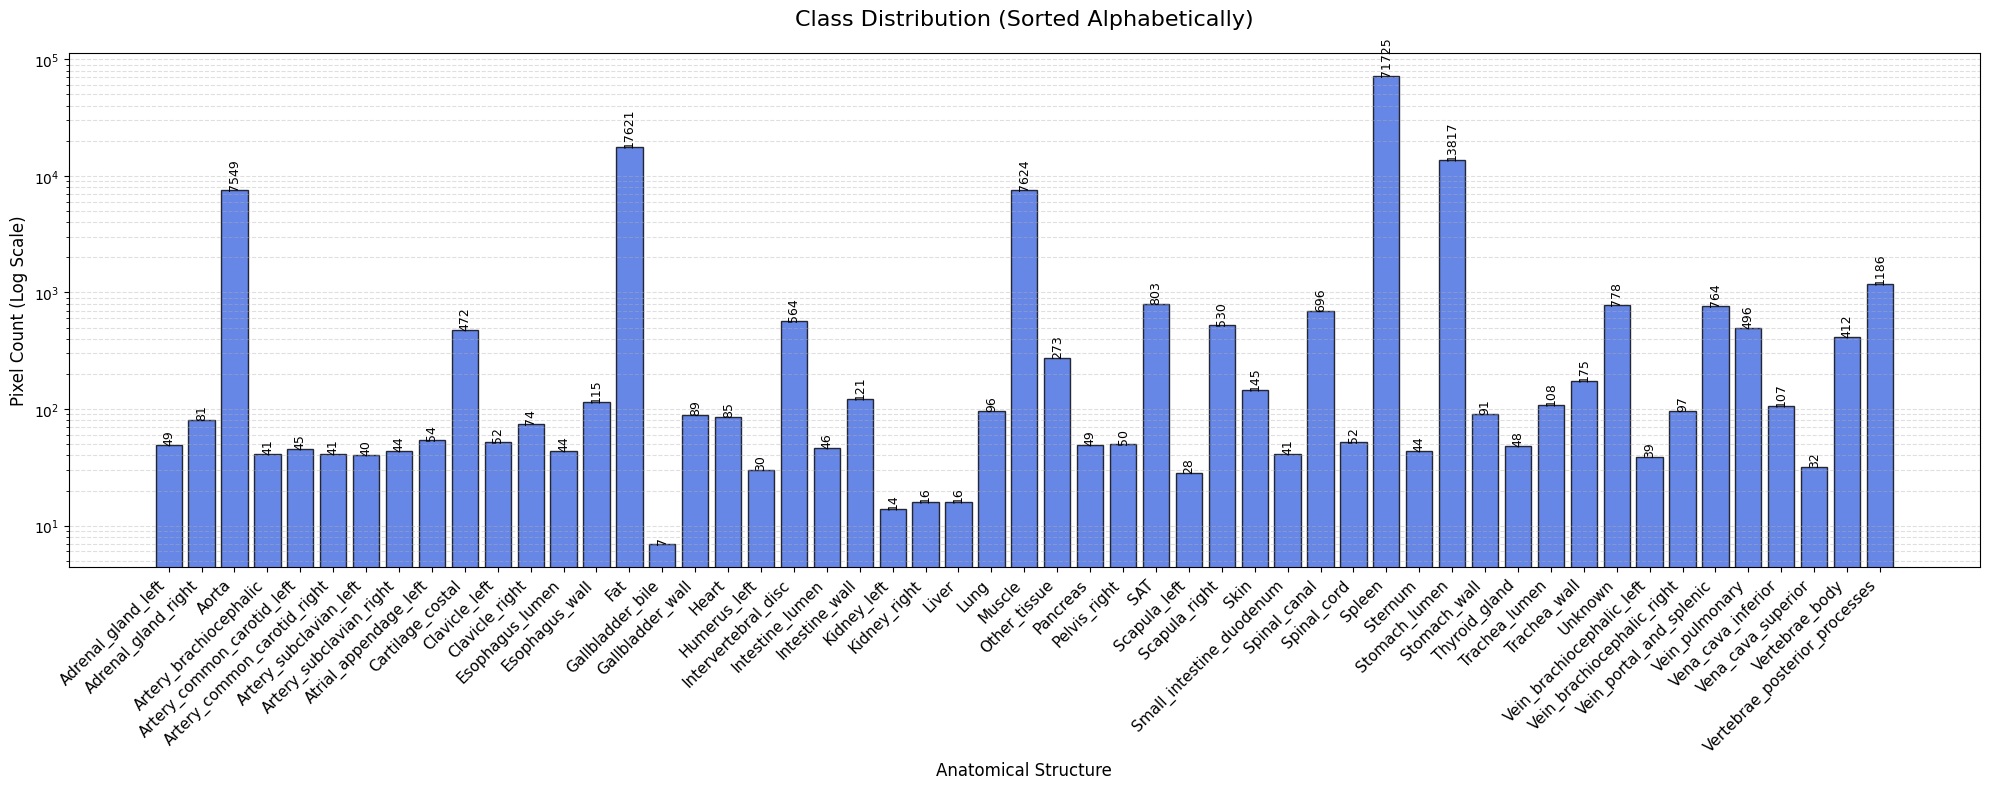

In [13]:
import matplotlib.pyplot as plt
import numpy as np

no_unk_labels = ["" if x == '__unused__' else x for x in original_labels]

counts = np.bincount(ex_segmentation.flatten().astype(int))
indices = np.arange(len(counts))

if len(no_unk_labels) < len(counts):
    diff = len(counts) - len(no_unk_labels)
    no_unk_labels.extend(["Unknown"] * diff)
elif len(no_unk_labels) > len(counts):
    no_unk_labels = no_unk_labels[:len(counts)]

mask = (counts > 0) & (np.array(no_unk_labels) != "")
filtered_labels = [no_unk_labels[i] for i in indices if mask[i]]
filtered_counts = counts[mask]

# Sort both lists alphabetically by label name
sorted_data = sorted(zip(filtered_labels, filtered_counts))
filtered_labels, filtered_counts = zip(*sorted_data)

plt.figure(figsize=(20, 8))

bars = plt.bar(range(len(filtered_labels)), filtered_counts, 
               color='royalblue', edgecolor='black', alpha=0.8)

plt.xticks(range(len(filtered_labels)), filtered_labels, 
           rotation=45, ha='right', fontsize=11)

plt.title('Class Distribution (Sorted Alphabetically)', fontsize=16, pad=20)
plt.xlabel('Anatomical Structure', fontsize=12)
plt.ylabel('Pixel Count (Log Scale)', fontsize=12)
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.4, which='both')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)}', 
             va='bottom', ha='center', fontsize=9, rotation=90)

plt.tight_layout()
plt.show()

In [14]:
np.unique(ex_segmentation)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80.])

In [15]:
print(ex_segmentation.dtype, np.max(ex_segmentation),np.min(ex_segmentation))

float64 80.0 0.0


### Check images all blacks

In [16]:
def check_black_slices(image):
    is_black = False
    cnt = 0
    black_slices = []
    for i in range(image.shape[2]):
        if np.all(image[:,:,i] == 0):
            black_slices.append(i)
            is_black = True
            cnt += 1
    return cnt, is_black, black_slices

In [17]:
# for file in sorted(os.listdir(DATA_PATH)):
#     if file.endswith('.npy'):
#         pat = np.load(DATA_PATH + '/' + file, allow_pickle=True).item()
#         cnt, is_black, black_slices = check_black_slices(pat['interpolated_intensity'])
#         if is_black:
#             pat_id = file.split('-')[1]
#             print(f'Patient {pat_id} has {cnt} black slices at indices {black_slices}')
# shape_vect = np.array(shapes)

### Remap labels
I want to remap the original labels in the interpolated segmentations into a new set of fewer grouped labels

In [18]:
original_labels

['Spleen',
 'Kidney_right',
 'Kidney_left',
 'Gallbladder_bile',
 'Liver',
 'Stomach_lumen',
 'Pancreas',
 'Adrenal_gland_right',
 'Adrenal_gland_left',
 'Lung',
 '__unused__',
 '__unused__',
 '__unused__',
 '__unused__',
 'Esophagus_lumen',
 'Trachea_lumen',
 'Thyroid_gland',
 'Intestine_lumen',
 'Small_intestine_duodenum',
 '__unused__',
 '__unused__',
 '__unused__',
 '__unused__',
 'Heart',
 'Aorta',
 'Vein_pulmonary',
 'Artery_brachiocephalic',
 'Artery_subclavian_right',
 'Artery_subclavian_left',
 'Artery_common_carotid_right',
 'Artery_common_carotid_left',
 'Vein_brachiocephalic_left',
 'Vein_brachiocephalic_right',
 'Atrial_appendage_left',
 'Vena_cava_superior',
 'Vena_cava_inferior',
 'Vein_portal_and_splenic',
 '__unused__',
 '__unused__',
 '__unused__',
 '__unused__',
 'Humerus_left',
 '__unused__',
 'Scapula_left',
 'Scapula_right',
 'Clavicle_left',
 'Clavicle_right',
 '__unused__',
 '__unused__',
 '__unused__',
 'Pelvis_right',
 'Spinal_cord',
 '__unused__',
 '__unused_

In [19]:
grouping_rules = {
    "__unused__": "Others",
    "Other_tissue": "Others",
    "Cartilage_costal": "Bones_and_cartilage",
    "Humerus_left": "Bones_and_cartilage",
    "Scapula_left": "Bones_and_cartilage",
    "Scapula_right": "Bones_and_cartilage",
    "Clavicle_left": "Bones_and_cartilage",
    "Clavicle_right": "Bones_and_cartilage",
    "Pelvis_right": "Bones_and_cartilage",
    "Sternum": "Bones_and_cartilage",
    "Cartilage_costal": "Bones_and_cartilage",
    "Intervertebral_disc": "Bones_and_cartilage",
    "Vertebrae_body": "Bones_and_cartilage",
    "Vertebrae_posterior_processes": "Bones_and_cartilage",
    "Spinal_canal": "Bones_and_cartilage",
    "Kidney_right": "Kidneys",
    "Kidney_left":  "Kidneys",
    "Adrenal_gland_right": "Kidneys",
    "Adrenal_gland_left": "Kidneys",
    "Lung": "Lungs",
    "Vein_pulmonary": "Blood_vessels",
    "Artery_brachiocephalic": "Blood_vessels",
    "Artery_subclavian_right": "Blood_vessels",
    "Artery_subclavian_left": "Blood_vessels",
    "Artery_common_carotid_right": "Blood_vessels",
    "Artery_common_carotid_left": "Blood_vessels",
    "Vein_brachiocephalic_left": "Blood_vessels",
    "Vein_brachiocephalic_right": "Blood_vessels",
    "Vena_cava_superior": "Blood_vessels",
    "Vena_cava_inferior": "Blood_vessels",
    "Vein_portal_and_splenic": "Blood_vessels",
    "Stomach_wall": "Stomach",
    "Stomach_lumen": "Stomach",
    "Esophagus_lumen": "Esophagus_and_trachea",
    "Esophagus_wall": "Esophagus_and_trachea",
    "Trachea_wall": "Esophagus_and_trachea",
    "Trachea_lumen": "Esophagus_and_trachea",
    "Thyroid_gland": "Esophagus_and_trachea",
    "Intestine_lumen": "Intestine",
    "Small_intestine_duodenum": "Intestine",
    "Intestine_wall": "Intestine",
    "Gallbladder_wall": "Gallbladder",
    "Gallbladder_bile": "Gallbladder",
    "Fat": "Fat",
    "SAT": "Fat",
    "Muscle": "Muscle",
    "Skin": "Skin",
    "Spleen": "Spleen",
    "Pancreas": "Pancreas",
    #"Heart": "Heart",
    "Atrial_appendage_left": "Heart",
    "Liver": "Liver",
    "Aorta": "Aorta",
    "Spleen": "Spleen",
    "Spinal_cord": "Spinal_cord",
}

In [20]:
new_labels = set()
for value in grouping_rules.values():
    new_labels.add(value)
new_labels.add("LV_Myocardium")
new_labels.add("LV_blood_pool")  # Add "Unknown" category for unused labels
new_labels.add("RV_blood_pool_myocardium")

new_labels = sorted(list(new_labels))
print(new_labels, len(new_labels))

['Aorta', 'Blood_vessels', 'Bones_and_cartilage', 'Esophagus_and_trachea', 'Fat', 'Gallbladder', 'Heart', 'Intestine', 'Kidneys', 'LV_Myocardium', 'LV_blood_pool', 'Liver', 'Lungs', 'Muscle', 'Others', 'Pancreas', 'RV_blood_pool_myocardium', 'Skin', 'Spinal_cord', 'Spleen', 'Stomach'] 21


In [53]:
lut = np.zeros(len(original_labels)+1, dtype=int)
for idx, label in enumerate(original_labels):
    if label in grouping_rules:
        group_name = grouping_rules[label]
        group_idx = new_labels.index(group_name)
        lut[idx+1] = group_idx # +1 IS CRUCIAL BECAUSE 0 IS THE BACKGROUND (AND WE WANT TO RE-MAP IT AS 0)
    else:
        lut[idx+1] = -1
        print(f'Warning: Label "{label}" not found in grouping rules. Assigned to -1.')

In [54]:
ex_segmentation = np.round(pat['interpolated_segmentation'][:,:,7])

In [55]:


ex_seg_remapped = lut[ex_segmentation.astype(int)]
np.unique(ex_seg_remapped), np.unique(ex_segmentation)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 17, 18,
        19, 20]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
        65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
        78., 79., 80.]))

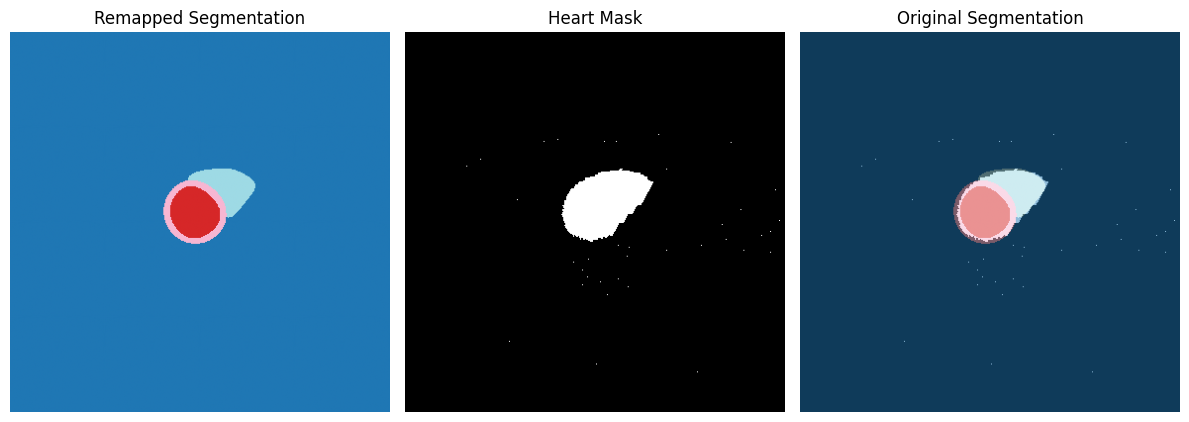

In [61]:
heart_mask = ex_seg_remapped == -1

fg = pat['mask_foreground'][:,:,7]

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(fg, cmap='tab20')
ax[0].set_title('Remapped Segmentation')
ax[0].axis('off')
ax[1].imshow(heart_mask, cmap='gray')
ax[1].set_title('Heart Mask')
ax[1].axis('off')
ax[2].imshow(fg, cmap='tab20')
ax[2].imshow(heart_mask, cmap='gray', alpha=0.5)
ax[2].set_title('Original Segmentation')
ax[2].axis('off')
plt.tight_layout()

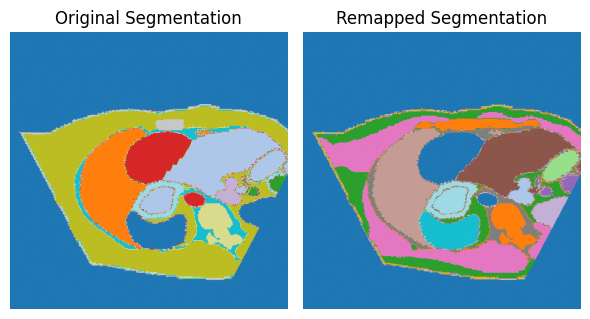

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(ex_segmentation, cmap='tab20')
ax[1].imshow(ex_seg_remapped, cmap='tab20')
ax[0].set_title('Original Segmentation')
ax[1].set_title('Remapped Segmentation')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()


In [26]:
num_classes = 81 # Il numero che abbiamo visto prima
one_hot_mask = np.eye(num_classes)[ex_segmentation.astype(int)]

print(one_hot_mask.shape) # Output: (H, W, 81)

(384, 384, 81)


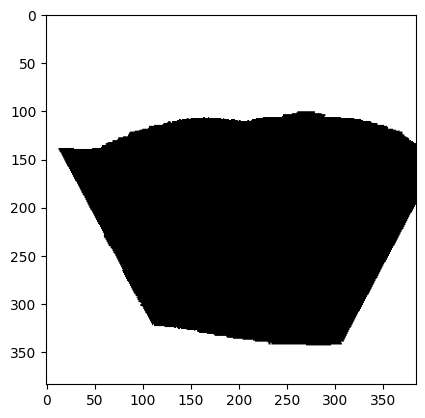

In [27]:
plt.imshow(one_hot_mask[:,:,0], cmap='gray')

## Masks foreground Analysis

In [28]:
ex_foreground = pat['mask_foreground']

float64


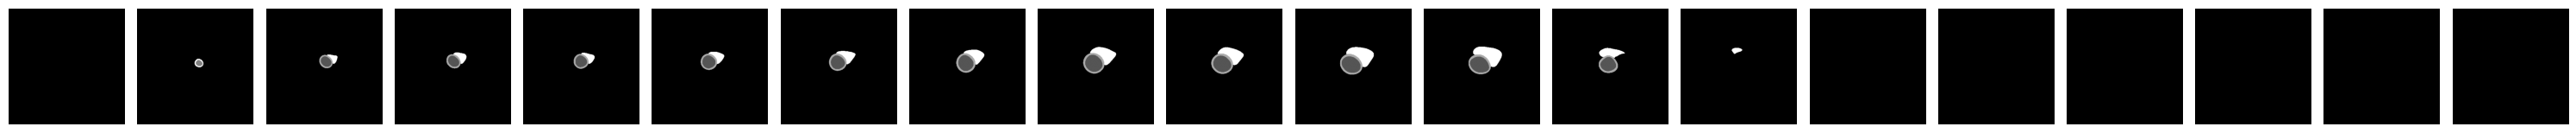

In [29]:
fig, ax = plt.subplots(1, ex_foreground.shape[2], figsize=(30, 30))
for i in range(ex_foreground.shape[2]):
    ax[i].imshow(ex_foreground[:,:,i], cmap='gray')
    ax[i].axis('off')
plt.tight_layout()

print(pat['mask_foreground'][:, :, slice_idx].dtype)

In [30]:
np.unique(pat['mask_foreground'][:, :, slice_idx]), pat['mask_foreground'].shape

(pyvista_ndarray([0., 1., 2., 3.]), (384, 384, 20))

In [31]:
empty_slices_mask = np.all(pat['mask_foreground'] == 0, axis=(0,1))


In [32]:
len(empty_slices_mask), pat['mask_foreground'].shape, np.sum(empty_slices_mask)

(20, (384, 384, 20), np.int64(7))

## Dataset dev

In [33]:
class DatasetDIDC(Dataset):
    def __init__(self, data_path, grouping_rules, target_size=(384, 384), num_input_classes=4, rm_black_slices=False):
        self.data_path = data_path
        self.grouping_rules = grouping_rules
        self.target_size = target_size
        self.rm_black_slices = rm_black_slices

        assert os.path.isdir(self.data_path), f"Data path {self.data_path} does not exist or is not a directory."
        assert self.grouping_rules is not None, "Grouping rules must be provided for label remapping."

        self.lut = self.generate_lut(self.grouping_rules, original_labels)

        foreground_list = []
        segm_masks_list = []

        counter = 0

        # Load all data into memory and resize on the fly if needed
        for file in sorted(os.listdir(self.data_path)):
            if file.endswith('.npy'):
                pat = np.load(self.data_path + '/' + file, allow_pickle=True).item()                

                fg = torch.from_numpy(pat['mask_foreground']).permute(2,0,1)
                mask = torch.from_numpy(pat['interpolated_segmentation']).float().permute(2,0,1)

                # Remove empty slices in the foreground if the option is enabled
                if self.rm_black_slices:
                    empty_slices_mask = self.check_black_foreground(fg)
                    fg = fg[~empty_slices_mask, ...]
                    mask = mask[~empty_slices_mask, ...]

                if fg.shape[1] != self.target_size[0] or fg.shape[2] != self.target_size[1]:
                    fg = TF.resize(fg, self.target_size, interpolation=TF.InterpolationMode.NEAREST)
                    mask = TF.resize(mask, self.target_size, interpolation=TF.InterpolationMode.NEAREST)
                    

                foreground_list.append(fg)
                segm_masks_list.append(mask)
            
            counter += 1
            if counter > 50:
                print("Loaded 10 patients, stopping for testing purposes.")
                break
        
        # remap segmentation masks using LUT (only for multi tissue maps)
        self.fg_tensor = torch.cat(foreground_list, dim=0).long()
        self.segm_masks_tensor = self.lut[torch.cat(segm_masks_list, dim=0).long()]

        # One hot encode fg tensor
        num_classes = self.fg_tensor.max().item() + 1
        assert num_input_classes == num_classes, f"Number of input classes ({num_input_classes}) does not match the number of unique labels in the foreground ({num_classes})."
        
        self.fg_tensor = F.one_hot(self.fg_tensor, num_classes=num_input_classes).permute(0, 3, 1, 2)

        
    @staticmethod
    def check_black_foreground(mask):
        assert mask.ndim == 3, "Input mask must be a 3D array (D, H, W)"
        assert isinstance(mask, torch.Tensor), "Input mask must be a torch.Tensor"

        flat_mask = mask.flatten(start_dim=1)

        return flat_mask.sum(dim=1) == 0


    @staticmethod
    def generate_lut(grouping_rules, original_labels):
        """
        Generate a Look-Up Table (LUT) for remapping original labels to new grouped labels based on provided grouping rules.
        The LUT is a numpy array where the (index +1) corresponds to the original label and the value at that index is the new grouped label index. 
        The LUT should have a length of max(original_labels) + 1 to accommodate the "background" label as 0.
        """
        new_labels = sorted(list(set(grouping_rules.values())))
        lut = np.zeros(len(original_labels)+1, dtype=int)
        for idx, label in enumerate(original_labels):
            if label in grouping_rules:
                group_name = grouping_rules[label]
                group_idx = new_labels.index(group_name)
                lut[idx+1] = group_idx
            else:
                print(f'Warning: Label "{label}" not found in grouping rules. Assigned to "Unknown".')
        return torch.from_numpy(lut).long()


    def __len__(self):
        return self.fg_tensor.shape[0]

    def __getitem__(self, idx):
        return {'input_label': self.fg_tensor[idx].float(), 'multiClassMask': self.segm_masks_tensor[idx]}

In [34]:
dataset = DatasetDIDC(DATA_PATH, grouping_rules, target_size=(384, 384), rm_black_slices=False)
lut = dataset.generate_lut(grouping_rules, original_labels)

Loaded 10 patients, stopping for testing purposes.


In [35]:
len(dataset), dataset.fg_tensor.shape, dataset.segm_masks_tensor.shape, dataset.fg_tensor.dtype, dataset.segm_masks_tensor.dtype

(1008,
 torch.Size([1008, 4, 384, 384]),
 torch.Size([1008, 384, 384]),
 torch.int64,
 torch.int64)

In [36]:
dataset[147]['input_label'].shape, dataset[147]['multiClassMask'].shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

In [37]:
dataset[147]['input_label'].dtype, dataset[147]['multiClassMask'].dtype

(torch.float32, torch.int64)

In [38]:
print(np.unique(dataset[147]['input_label']), np.unique(dataset[147]['multiClassMask']))

[0. 1.] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


Randomly selected index: 755


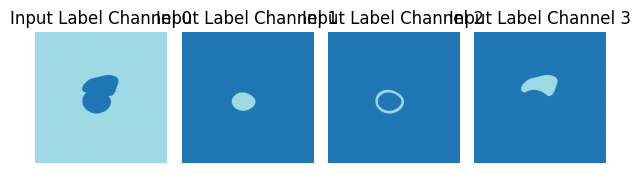

In [39]:
rnd_idx = np.random.randint(0, len(dataset))
print(f"Randomly selected index: {rnd_idx}")

fig, ax = plt.subplots(1, 4, figsize=(6, 6))
for i in range(dataset[0]['input_label'].shape[0]):
    ax[i].imshow(dataset[rnd_idx]['input_label'][i], cmap='tab20')
    ax[i].set_title(f'Input Label Channel {i}')
    ax[i].axis('off')
plt.tight_layout()


(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

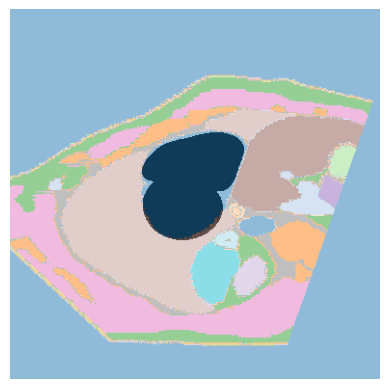

In [40]:
plt.imshow(dataset[rnd_idx]['input_label'][0], cmap='gray')

plt.imshow(dataset[rnd_idx]['multiClassMask'], cmap='tab20', alpha=0.5)
plt.axis('off')

In [41]:
for idx in range(len(dataset)):
    inp = dataset[idx]['input_label']
    inp_np = inp.numpy()
    empty_slices_mask = np.all(inp_np == 0, axis=(0, 1))
    if np.sum(empty_slices_mask) > 0:
        print(empty_slices_mask)
        

In [42]:
empty_slices_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,